## Project overview

This project focuses on a Natural Language Processing (NLP) challenge using Twitter data to classify whether a given tweet is about a real disaster or not. Twitter’s role as a real-time communication tool during emergencies makes this task especially relevant for disaster relief organizations and news agencies interested in automated monitoring.

The dataset is relatively small and manageable, making it an excellent entry point for those new to NLP. The task involves building and evaluating different machine learning models, such as Logistic Regression, XGBoost, and BERT, to determine their effectiveness in text classification.

**Dataset**

The dataset consists of roughly 10,000 tweets, each hand-labeled as disaster-related (1) or not (0). Alongside the text of the tweet, additional fields such as the ID and keyword/location metadata are provided. 

**Evaluation Metric:**

Model performance is measured using the F1-score, which balances precision and recall and is particularly well-suited for imbalanced classification tasks like this one.

### Dataset Description

- The text of a tweet
- A keyword from that tweet 
- The location the tweet was sent from 


In [1]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 11.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvid

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import os
import matplotlib.pyplot as plt
%matplotlib inline 
plt.style.use('ggplot')
import re
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRFClassifier
from sklearn.metrics import f1_score
from wordcloud import WordCloud
from transformers import (
    Trainer,
    TrainingArguments,
    DistilBertForSequenceClassification,
    DistilBertTokenizerFast,
    DataCollatorWithPadding,
    BertForSequenceClassification,
    BertTokenizerFast
)
from datasets import Dataset
import torch
import evaluate
import nltk
from nltk.corpus import stopwords
os.environ["WANDB_DISABLED"] = "true"
# Download stopwords from nltk
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-09-18 17:59:05.180099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758218345.406669      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758218345.476307      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [3]:
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
def summary_info(df):
  print("INFO")
  df.info()
  print('Missing Data')
  missing_data = df.isnull().sum()
  display(missing_data[missing_data>0])
  print('Duplicated data')
  display(df.duplicated().sum())
summary_info(train_df)

INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
Missing Data


keyword       61
location    2533
dtype: int64

Duplicated data


0

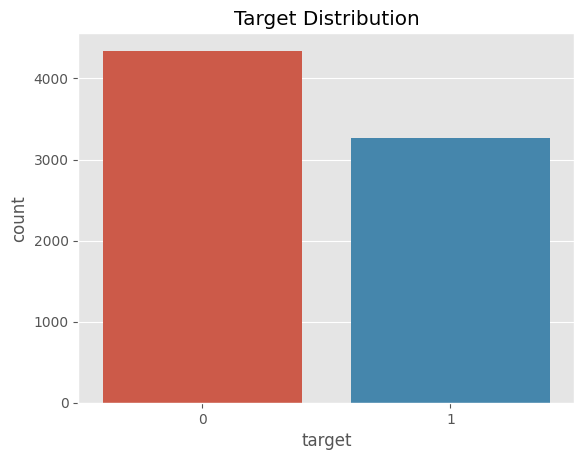

In [5]:
sns.countplot(train_df,x='target');
plt.title("Target Distribution");

In [6]:
#sample view a tweet 
train_df['text'][10]

'Three people died from the heat wave so far'

## Data Cleaning 

**Text Preprocessing**

Removed stopwords and applied TF-IDF vectorization.

Location cleaned where possible, but primary modeling focus is on text.

In [7]:
def clean_and_fill_keyword_from_text(df):
  keywords = df['keyword'].dropna().unique().tolist()
  keywords = [k.lower() for k in keywords]
  df['keyword'] = df['keyword'].str.replace('%', ' ')
  df['keyword'] = df['keyword'].str.replace(r'\d+', '', regex=True)

  def find_keywords(row):
    if pd.isna(row['keyword']):
      text = row['text'].lower()
      for kw in keywords:
        if kw in text:
          return kw
      return 'missing'
    return row['keyword']
  df['keyword'] = df.apply(find_keywords,axis=1)
  return df
train_df = clean_and_fill_keyword_from_text(train_df)

def preprocess_text(df):
  #clean_text
  df['text'] = (
      df['text']
      .str.lower()
      .str.replace(r"http\S+|www\S+|https\S+", " url ", regex=True) # remove links
      .str.replace(r"@\w+", " user ", regex=True) # replace mentions
      .str.replace(r"#", "", regex=True) # remove hashtag symbol
      .str.replace(r"[^a-zA-Z0-9\s]", " ", regex=True) # remove punctuation
  )
  return df
train_df = preprocess_text(train_df)

In [8]:
def normalize_location(loc):
    if pd.isna(loc) or not isinstance(loc, str):
        return "missing"
    loc = loc.lower().strip()
    loc = re.sub(r"[^a-z\s,]", "", loc)  
    loc = re.sub(r"\s+", " ", loc)       
    return loc

    
LOCATION_MAP = {
    # Countries
    "usa": "united states",
    "us": "united states",
    "u.s.": "united states",
    "united states of america": "united states",
    "uk": "united kingdom",
    "u.k.": "united kingdom",
    "england": "united kingdom",
    "great britain": "united kingdom",
    
    # Cities
    "nyc": "new york",
    "new york city": "new york",
    "new york nyc": "new york",
    "n.y.c.": "new york",
    "la": "los angeles",
    "los angeles": "los angeles",
    "sf": "san francisco",
    "san francisco bay area": "san francisco"
}

def clean_location(loc):
    loc = normalize_location(loc)

    if loc == "" or loc == "location":
        return "missing"
    
    if re.match(r"^-?\d+(\.\d+)?\s*,\s*-?\d+(\.\d+)?$", loc):
        return "coordinates"
    
    if any(word in loc for word in ["world", "earth", "global", "everywhere", "international"]):
        return "global"
    
    if "/" in loc:
        return loc.split("/")[0].strip()
    
    if loc in LOCATION_MAP:
        return LOCATION_MAP[loc]
    
    return loc
train_df["location_clean"] = train_df["location"].apply(clean_location)


## EDA

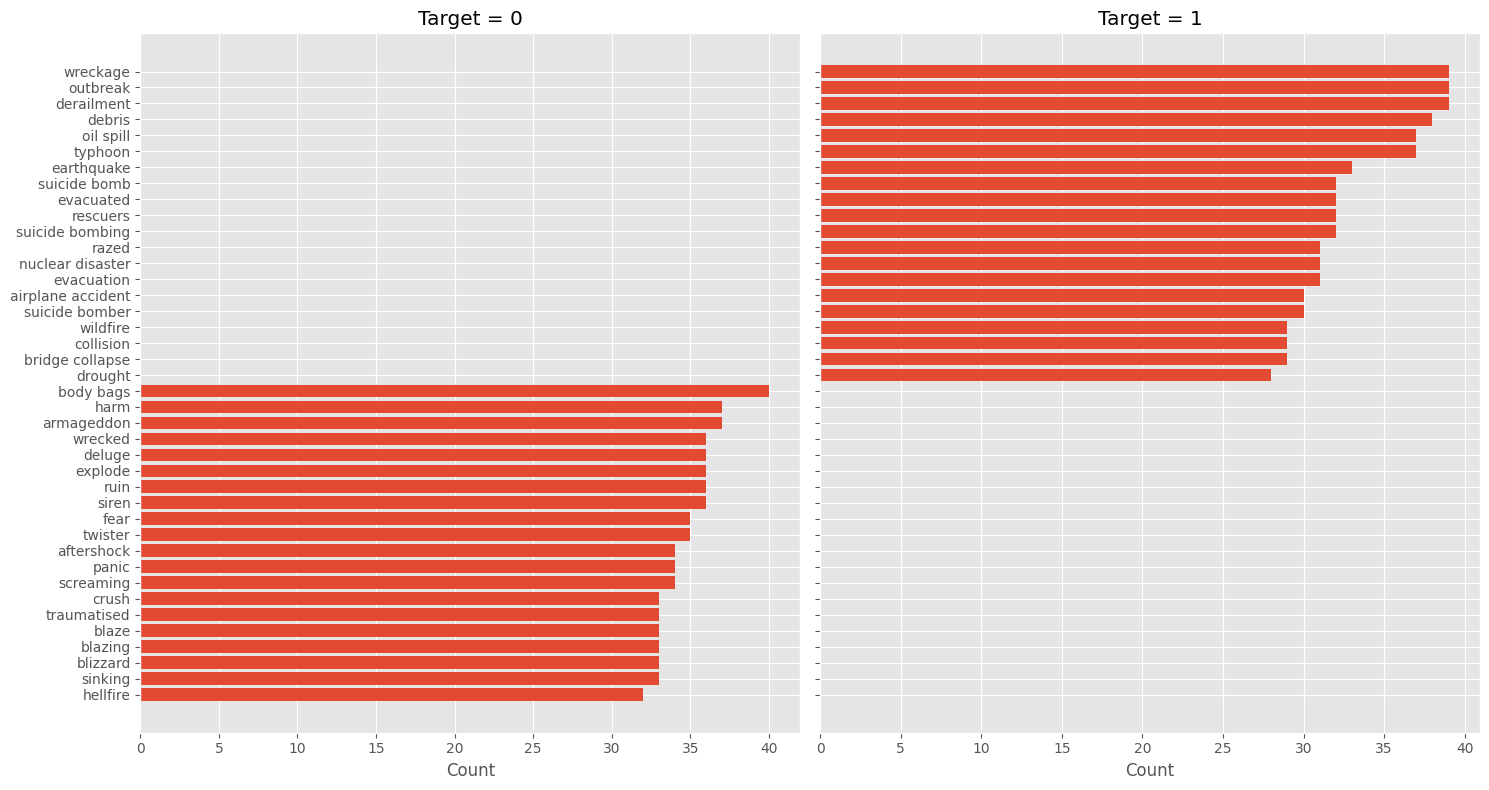

In [9]:
def plot_top_20(df, target_col='target', keyword_col='keyword', top_n=20):
    """
    Plots top N keywords for each target class in subplots.
    """
    targets = df[target_col].unique()
    fig, axes = plt.subplots(1, len(targets), figsize=(15,8), sharey=True)
    
    # ensure axes is iterable
    if len(targets) == 1:
        axes = [axes]  
    
    for i, t in enumerate(sorted(targets)):
        top_keywords = df[df[target_col]==t][keyword_col].value_counts().head(top_n)
        axes[i].barh(top_keywords.index[::-1], top_keywords.values[::-1])
        axes[i].set_title(f"Target = {t}")
        axes[i].set_xlabel("Count")
    
    plt.tight_layout()
    plt.show()
plot_top_20(train_df, 'target', 'keyword', 20)

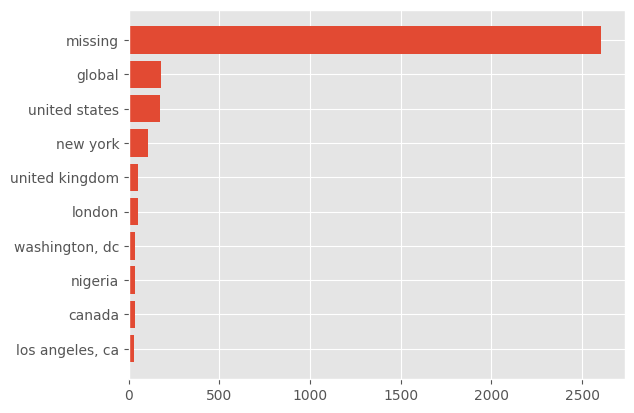

In [10]:
#Top 10 locations 
top_10 = train_df['location_clean'].value_counts().head(10)
plt.barh(top_10.index[::-1], top_10.values[::-1]);

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


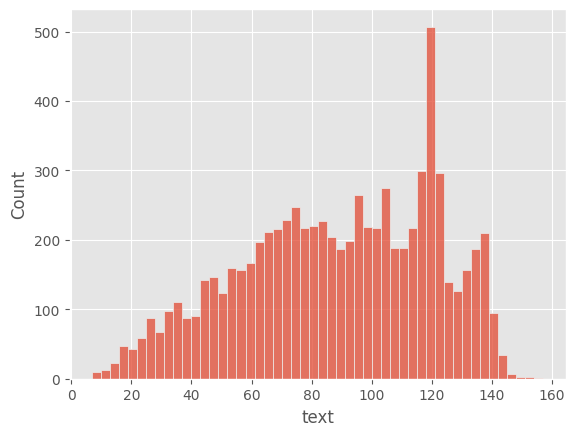

In [11]:
# Tweet length distribution
sns.histplot(train_df['text'].apply(len), bins=50);

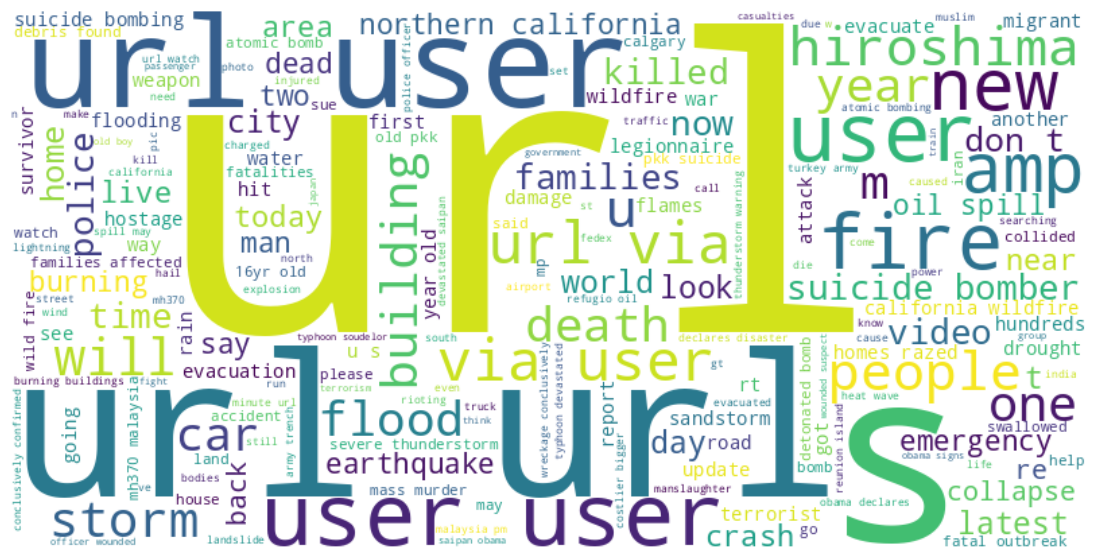

In [12]:
#Word clouds for disaster vs non-disaster tweets
disaster_text = " ".join(train_df[train_df['target']==1]['text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(disaster_text)

plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Plan of Analysis 

Insights from EDA:

- The dataset is slightly imbalanced (more non-disaster tweets than disaster ones).

- Keywords and locations give some signal but are noisy and incomplete. Missing values were imputed using:

    - Kewywords in tweet
    - "Missing" used where no keywords found in tweet.  

- Tweet length distribution shows most are short and approximately left skewed.

- Word clouds and keyword frequency suggest clear lexical differences between disaster and non-disaster tweets.

## NLP Stack Model 

**Base Models**

- Logistic Regression: Linear baseline with TF-IDF.

- XGBoost: Gradient-boosted trees with TF-IDF.

- BERT: Fine-tuned transformer model on raw tweet text.

**Ensembling via Stacking**

- Used 5-fold cross-validation to generate Out-of-Fold (OOF) predictions for LR, XGBoost, and BERT.

- Combined OOF predictions as meta-features to train a Random Forest meta-model.

**Evaluation Strategy**

Computed F1-scores for each base model (LR, XGBoost, BERT) and for the stacking ensemble.

Final BERT model trained on the full dataset for test-time predictions.

In [13]:
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

# Load the F1 metric from the evaluate library
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    """Computes the F1-score from the model's predictions."""
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return f1_metric.compute(predictions=predictions, references=labels)

# TF-IDF feature extraction with stopwords
def get_tfidf_features(X, y=None):
    stop_words = list(stopwords.words('english'))
    tfidf = TfidfVectorizer(max_features=1000, ngram_range=(1,2), stop_words=stop_words)
    if y is None: # For test set transformation
        return tfidf.transform(X), tfidf
    else: # For train/valid splitting
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=.2, random_state=42)
        X_train_tfidf = tfidf.fit_transform(X_train)
        X_valid_tfidf = tfidf.transform(X_valid)
        return X_train_tfidf, X_valid_tfidf, y_train, y_valid, tfidf

# Base Model Training and Prediction
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def predict_model(model, X):
    return model.predict_proba(X)[:,1]

def encode_text(texts, tokenizer, max_length=128):
    if isinstance(texts, (pd.Series, np.ndarray)):
        texts = texts.astype(str).tolist()
    elif isinstance(texts, str):
        texts = [texts]

    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=max_length,
        return_tensors="pt"
    )
    return {
        "input_ids": encodings["input_ids"],
        "attention_mask": encodings["attention_mask"]
    }

# DistilBERT Training and Prediction
def distilbert_train(X_train, X_valid, y_train, 
                     y_valid, device="cpu", epochs=3, save_path="bert_model"):
    model_name = "bert-base-uncased" 
    tokenizer = BertTokenizerFast.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2).to(device)

    train_encodings = encode_text(X_train, tokenizer)
    val_encodings = encode_text(X_valid, tokenizer)

    train_encodings["labels"] = y_train.tolist()
    val_encodings["labels"] = y_valid.tolist()

    train_dataset = Dataset.from_dict(train_encodings)
    val_dataset = Dataset.from_dict(val_encodings)

    training_args = TrainingArguments(
        output_dir="./results_bert",
        num_train_epochs=epochs,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        eval_steps=50,
        logging_steps=50,
        save_strategy="no",
        seed=42,
        learning_rate=5e-5,
        load_best_model_at_end=True,
        metric_for_best_model="f1"
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics
    )

    trainer.train()
    # Save the trained model
    trainer.save_model(save_path) 

    predictions = trainer.predict(val_dataset)
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()
    return probs

def distilbert_predict(X_test, model_path="bert_model", device="cpu"):
    tokenizer = BertTokenizerFast.from_pretrained(model_path)
    model = BertForSequenceClassification.from_pretrained(model_path).to(device)
    
    test_encodings = encode_text(X_test, tokenizer)
    test_dataset = Dataset.from_dict(test_encodings)
    
    trainer = Trainer(model=model)
    predictions = trainer.predict(test_dataset)
    probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()
    return probs

# Stacking model 
def stack_model(base_preds, y_valid):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(base_preds, y_valid)
    return model

# Ensemble function for base models using K-Fold Cross-Validation for stacking
def get_oof_preds_and_test_preds(model_class, X_train, y_train, X_test, n_splits=5):
    oof_preds = np.zeros(X_train.shape[0])
    test_preds = np.zeros(X_test.shape[0])
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    for _, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train)):
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, _ = y_train[train_idx], y_train[val_idx]
        
        model = train_model(model_class(), X_tr, y_tr)
        oof_preds[val_idx] = predict_model(model, X_val)
        # Ensemble predictions on the test set
        test_preds += predict_model(model, X_test) / n_splits 
    return oof_preds, test_preds


In [14]:
X = train_df['text'].values
y = train_df['target'].values
X_test = test_df['text'].values

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#Base Models with TF-IDF and K-Fold Stacking
X_tfidf_full = TfidfVectorizer(max_features=1000, 
                               ngram_range=(1,2), 
                               stop_words=stopwords.words('english')).fit_transform(X)
X_test_tfidf = TfidfVectorizer(max_features=1000, 
                               ngram_range=(1,2), 
                               stop_words=stopwords.words('english')).fit(X).transform(X_test)

# Get Out-of-Fold (OOF) and test predictions for LR and XGBoost
lr_oof_preds, lr_test_preds = get_oof_preds_and_test_preds(LogisticRegression,
                                                           X_tfidf_full, y, X_test_tfidf)
xgb_oof_preds, xgb_test_preds = get_oof_preds_and_test_preds(XGBRFClassifier,
                                                             X_tfidf_full, y, X_test_tfidf)

# Generate OOF predictions for BERT Model 
bert_oof_preds = np.zeros(X.shape[0])
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    X_train_fold, X_val_fold = X[train_idx], X[val_idx]
    y_train_fold, y_val_fold = y[train_idx], y[val_idx]

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", num_labels=2
    ).to(device)

    train_dataset = Dataset.from_dict({
        "input_ids": encode_text(X_train_fold, tokenizer)["input_ids"],
        "attention_mask": encode_text(X_train_fold, tokenizer)["attention_mask"],
        "labels": y_train_fold.tolist()
    })
    val_dataset = Dataset.from_dict({
        "input_ids": encode_text(X_val_fold, tokenizer)["input_ids"],
        "attention_mask": encode_text(X_val_fold, tokenizer)["attention_mask"],
        "labels": y_val_fold.tolist()
    })

    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir=f"./results_bert_fold_{fold}",
            num_train_epochs=1,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=32,
            logging_steps=50,
            save_strategy="no",
            seed=42,
            learning_rate=5e-5,
            report_to="none"
        ),
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics
    )

    trainer.train()
    predictions = trainer.predict(val_dataset)
    bert_oof_preds[val_idx] = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()

# Train Stacking Model on OOF Predictions
meta_x_train = np.column_stack([lr_oof_preds, xgb_oof_preds, bert_oof_preds])
meta_model = stack_model(meta_x_train, y)

def print_score(model_name, model_pred, y_valid):
    oof_class = (model_pred > 0.5).astype(int)
    score = f1_score(y_valid, oof_class)
    print(f'{model_name} F1-Score: {score:.4f}')

models = {
    'Logistic Regression': lr_oof_preds,
    'XGBoost': xgb_oof_preds,
    'BERT': bert_oof_preds
}

# Calculate and print F1 scores
for name, preds in models.items():
    print_score(name, preds, y)

#Stacking model F1-score on the OOF predictions
stacking_preds = meta_model.predict(meta_x_train)
stacking_f1 = f1_score(y, stacking_preds)
print(f"Stacking Model F1-Score: {stacking_f1:.4f}")

#Train a final BERT model on the full training set
bert_final_model_path = "final_bert_model"
    
tokenizer_final = BertTokenizerFast.from_pretrained("bert-base-uncased")
model_final = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=2
).to(device)

train_dataset_final = Dataset.from_dict({
    "input_ids": encode_text(X, tokenizer_final)["input_ids"],
    "attention_mask": encode_text(X, tokenizer_final)["attention_mask"],
    "labels": y.tolist()
})

trainer_final = Trainer(
        model=model_final,
        args=TrainingArguments(
        output_dir="./final_bert_results",
        num_train_epochs=3,
        per_device_train_batch_size=16,
        logging_steps=50,
        save_strategy="no",
        seed=42,
        learning_rate=5e-5,
        report_to="none"
    ),
    train_dataset=train_dataset_final,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer_final)
)

trainer_final.train()
trainer_final.save_model(bert_final_model_path)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.541200
100,0.477700
150,0.440600
200,0.435000
250,0.433500
300,0.419000
350,0.350600


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.542800
100,0.426000
150,0.419200
200,0.449900
250,0.415400
300,0.411300
350,0.399700


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.545900
100,0.458300
150,0.511900
200,0.448600
250,0.419200
300,0.412400
350,0.412500


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.516200
100,0.461200
150,0.398700
200,0.452100
250,0.432100
300,0.411900
350,0.382600


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.539800
100,0.448300
150,0.410500
200,0.420700
250,0.396600
300,0.388300
350,0.368500


Logistic Regression F1-Score: 0.7344
XGBoost F1-Score: 0.5626
BERT F1-Score: 0.8014
Stacking Model F1-Score: 0.9934


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
50,0.529200
100,0.469900
150,0.485900
200,0.498500
250,0.392200
300,0.391800
350,0.447600
400,0.409400
450,0.405800
500,0.395400


In [15]:
#Generate test predictions for all models
bert_test_preds = distilbert_predict(X_test, model_path=bert_final_model_path, device=device)
meta_x_test = np.column_stack([lr_test_preds, xgb_test_preds, bert_test_preds])
final_test_preds = meta_model.predict(meta_x_test)

submission = pd.DataFrame({
    'id': test_df['id'],  
    'target': final_test_preds
})

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [16]:
submission.to_csv('submission.csv', index=False)